<a href="https://colab.research.google.com/github/amamory/MNIST-Quantized/blob/master/MNIST_Quantized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Libraries

In [0]:
import tensorflow as tf
print("TensorFlow version is "+tf.__version__)

import matplotlib.pyplot as plt

import numpy as np
# from keras.preprocessing import image

TensorFlow version is 2.2.0-rc2


Create Dataset

In [0]:
# Get MNIST dataset
mnist = tf.keras.datasets.mnist
# Load its data into training and test vectors
(x_train, y_train),(x_test, y_test) = mnist.load_data()
# Normalize the data
x_train, x_test = x_train / 255.0, x_test / 255.0
# Collect feature size info
imgSize0=len(x_train[0])
imgSize1=len(x_train[0][0])
numPixels=imgSize0*imgSize1
numTrainImages=len(x_train)
featureShape=(1,imgSize0,imgSize1)

print("Training dataset has "+str(numTrainImages))
print("Testing dataset has "+str(len(x_test)))
print("Feature shape is "+str(featureShape))

Training dataset has 60000
Testing dataset has 10000
Feature shape is (1, 28, 28)


Create Neural Network

In [0]:
# Clearup everything before running
tf.keras.backend.clear_session()
# Create model
model = tf.keras.models.Sequential()
# Add layers
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))
# Build model and print summary
model.build(input_shape=featureShape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  6280      
_________________________________________________________________
dense_1 (Dense)              multiple                  90        
Total params: 6,370
Trainable params: 6,370
Non-trainable params: 0
_________________________________________________________________


Train Neural Network

Compiling Model
Training Model
Epoch 1/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.5721 - accuracy: 0.8402
Epoch 2/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.3522 - accuracy: 0.9000
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3252 - accuracy: 0.9087
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3109 - accuracy: 0.9125
Epoch 5/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2996 - accuracy: 0.9158
Epoch 6/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2913 - accuracy: 0.9183
Epoch 7/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2841 - accuracy: 0.9198
Epoch 8/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2781 - accuracy: 0.9218
Epoch 9/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2742 - accuracy: 0.9226
Epoch 10/10
1875/1875 [============================

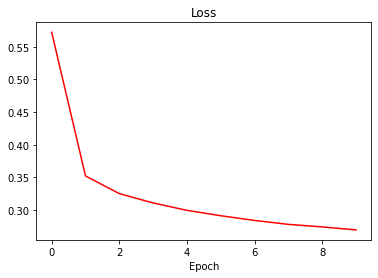

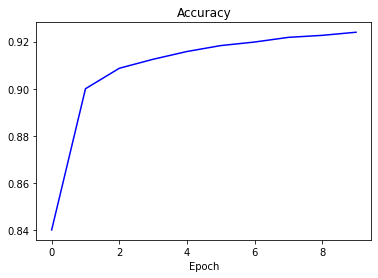

Testing Model
313/313 [==============================] - 0s 1ms/step - loss: 0.2863 - accuracy: 0.9178
Saving Model
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./model/assets


In [0]:
# Compile model
print("Compiling Model")
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Train
print("Training Model")
history = model.fit(x_train, y_train, epochs=10)
plt.plot(history.history["loss"], color='r')
plt.title("Loss")
plt.xlabel("Epoch")
plt.show()
plt.plot(history.history["accuracy"], color='b')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.show()
# Test
print("Testing Model")
model.evaluate(x_test, y_test)
# Save model
print("Saving Model")
model.save('./model') 

Quantize Model

In [0]:
## From https://www.tensorflow.org/lite/convert/python_api
# Load model, set shape and convert to TFLite
loadedModel = tf.saved_model.load("./model")
concrete_func = loadedModel.signatures[tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
concrete_func.inputs[0].set_shape(featureShape)
print(concrete_func.inputs)
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()
open("model.tflite", "wb").write(tflite_model)
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
print(input_details)
output_details = interpreter.get_output_details()

# get details for each layer
# all_layers_details = interpreter.get_tensor_details() 
# for layer in all_layers_details:
  # print(str(layer['index']))
  # to store layer's metadata in group's metadata
  # print(layer['name'])
  # print(layer['shape'])
  # grp.attrs["dtype"] = all_layers_details[i]['dtype']
  # print(layer['quantization'])
  # to store the weights in a dataset
  # print(interpreter.get_tensor(layer['index']))

# Test model
errorCount=0
for idx in range(len(x_test)):
  input_data = np.array([x_test[idx]], dtype=np.float32)
  interpreter.set_tensor(input_details[0]['index'], input_data)
  interpreter.invoke()
  output_data = interpreter.get_tensor(output_details[0]['index'])
  output_data = list(output_data[0])
  inferred = output_data.index(max(output_data))
  if(y_test[idx]!=inferred):
    errorCount = errorCount + 1
  # print("Expected "+str(y_test[idx])+" - Got "+str(inferred))
print("Found a total of %d errors in %d tests. Precision of %f" % (errorCount, len(x_test), 1-(errorCount/len(x_test))))


[<tf.Tensor 'input_1:0' shape=(1, 28, 28) dtype=float32>, <tf.Tensor 'unknown:0' shape=() dtype=resource>, <tf.Tensor 'unknown_0:0' shape=() dtype=resource>, <tf.Tensor 'unknown_1:0' shape=() dtype=resource>, <tf.Tensor 'unknown_2:0' shape=() dtype=resource>]
[{'name': 'input_1', 'index': 0, 'shape': array([ 1, 28, 28], dtype=int32), 'shape_signature': array([ 1, 28, 28], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Found a total of 814 errors in 10000 tests. Precision of 0.918600


In [0]:
tflite_model.

AttributeError: ignored

[<tf.Variable 'sequential/l1_dense/kernel:0' shape=(784, 8) dtype=float32>, <tf.Variable 'sequential/l1_dense/bias:0' shape=(8,) dtype=float32>, <tf.Variable 'sequential/l2_dense/kernel:0' shape=(8, 10) dtype=float32>, <tf.Variable 'sequential/l2_dense/bias:0' shape=(10,) dtype=float32>]
Kernel sequential/l1_dense/kernel:0, with 8 Neurons with 784 Synapses


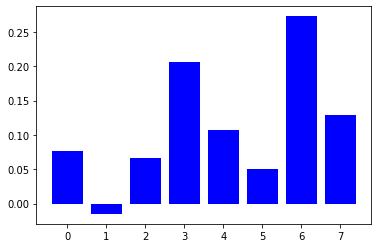

  Neuron 0 weights:


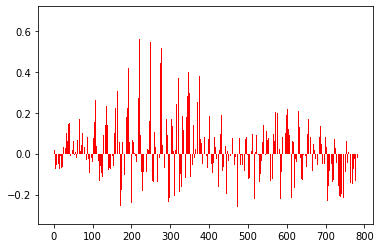

  Neuron 1 weights:


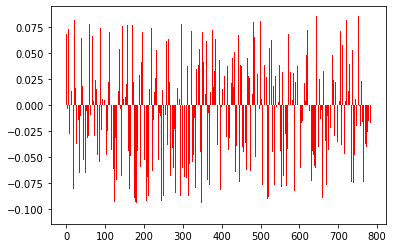

  Neuron 2 weights:


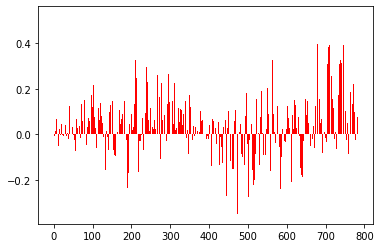

  Neuron 3 weights:


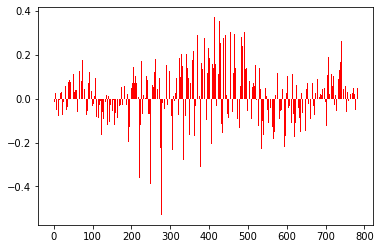

  Neuron 4 weights:


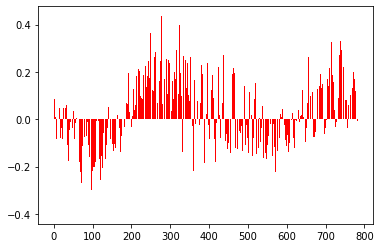

  Neuron 5 weights:


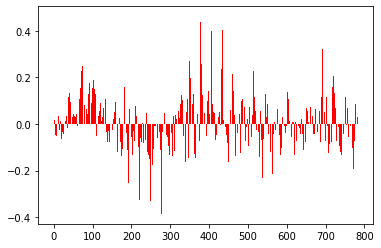

  Neuron 6 weights:


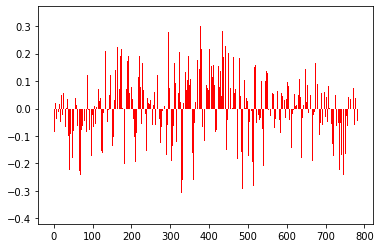

  Neuron 7 weights:


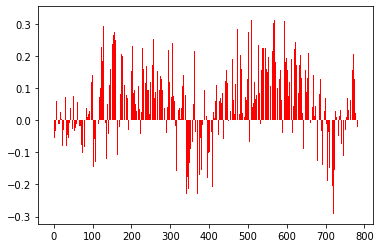

Kernel sequential/l2_dense/kernel:0, with 10 Neurons with 8 Synapses


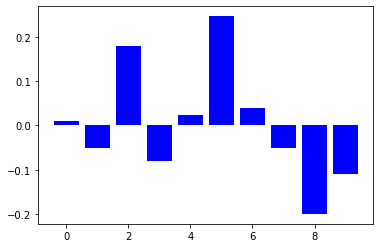

  Neuron 0 weights:


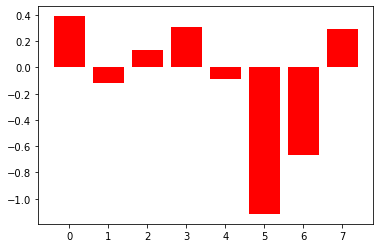

  Neuron 1 weights:


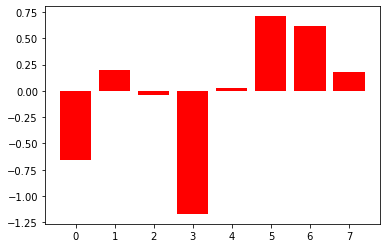

  Neuron 2 weights:


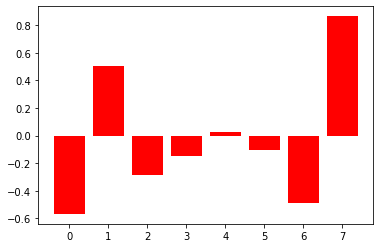

  Neuron 3 weights:


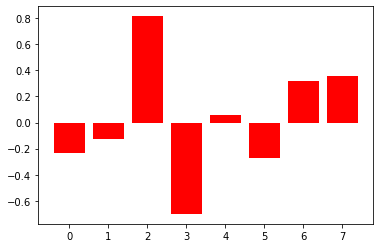

  Neuron 4 weights:


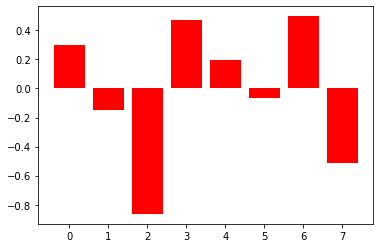

  Neuron 5 weights:


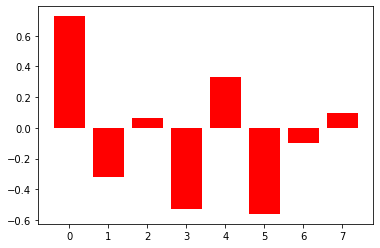

  Neuron 6 weights:


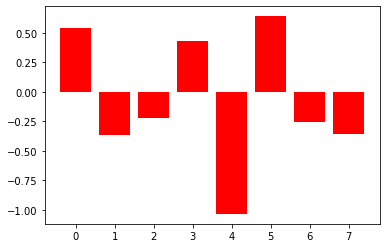

  Neuron 7 weights:


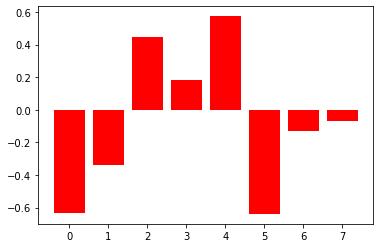

  Neuron 8 weights:


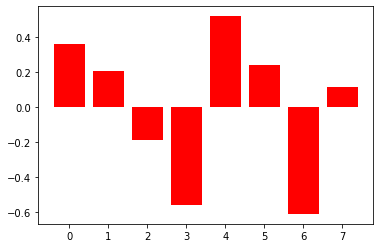

  Neuron 9 weights:


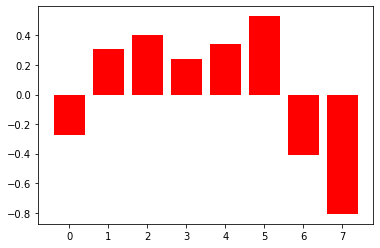

In [0]:
print(tf.trainable_variables())

neuronDict = {}

l1Kernel = tf.trainable_variables(scope='sequential/l1_dense/kernel')[0]
l1Bias = tf.trainable_variables(scope='sequential/l1_dense/bias')[0]

l1KernelSynapses = l1Kernel.shape[0]
l1KernelNeurons = l1Kernel.shape[1]

print("Kernel %s, with %d Neurons with %d Synapses" % (l1Kernel.name, l1KernelNeurons, l1KernelSynapses))
# print("  Bias:")
plt.bar(range(len(l1Bias.eval())), l1Bias.eval(), color='b')
plt.show()
neuronDict[0] = {}
for neuron in range(l1KernelNeurons):
  neuronDict[0][neuron] = {}
  neuronDict[0][neuron]["bias"] = l1Bias.eval()[neuron]
  neuronDict[0][neuron]["weights"] = l1Kernel.eval()[:,neuron]
  print("  Neuron %d weights:" % (neuron))
  neuronWeights = neuronDict[0][neuron]["weights"]
  plt.bar(range(len(neuronWeights)), neuronWeights, color='r')
  plt.show()
#   print(neuronWeights)

l2Kernel = tf.trainable_variables(scope='sequential/l2_dense/kernel')[0]
l2Bias = tf.trainable_variables(scope='sequential/l2_dense/bias')[0]

l2KernelSynapses = l2Kernel.shape[0]
l2KernelNeurons = l2Kernel.shape[1]

print("Kernel %s, with %d Neurons with %d Synapses" % (l2Kernel.name, l2KernelNeurons, l2KernelSynapses))
# print("  Bias:")
plt.bar(range(len(l2Bias.eval())), l2Bias.eval(), color='b')
plt.show()
neuronDict[1] = {}
for neuron in range(l2KernelNeurons):
  neuronDict[1][neuron] = {}
  neuronDict[1][neuron]["bias"] = l2Bias.eval()[neuron]
  neuronDict[1][neuron]["weights"] = l2Kernel.eval()[:,neuron]
  print("  Neuron %d weights:" % (neuron))
  neuronWeights = neuronDict[1][neuron]["weights"]
  plt.bar(range(len(neuronWeights)), neuronWeights, color='r')
  plt.show()
#   print(neuronWeights)

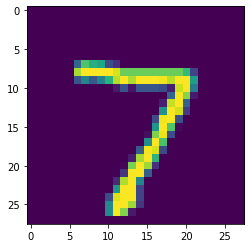

7
[[1.15582452e-03 2.67746447e-08 1.16429335e-04 2.06948188e-03
  8.10551285e-07 1.17924290e-04 2.96817182e-10 9.94935095e-01
  4.34446010e-05 1.56107615e-03]]

# Code starts here

from cktGen.engine import Engine
from cktGen.core.models.component import Component
import io
import os

e = Engine()
# Collect reference to Gem5Toolbox instance
for toolbox in e.toolboxManager.toolboxes:
	if toolbox.__class__.__name__ == "Gem5Toolbox":
		tb = toolbox
e.loadLibrary(os.path.expandvars("${NEURAL_ARTIST_PATH}/lib/cktGen/basic_lib/basic_lib.py"))
e.loadLibrary(os.path.expandvars("${NEURAL_ARTIST_PATH}/lib/cktGen/neuron_lib/neuron_lib.py"))

neuronClass = e.resources.getComponent("neuron_lib", "neuron2")
writeClass = e.resources.getCell("basic_lib", "write")
readClass = e.resources.getCell("basic_lib", "read")

top = Component("top")

neuronL0U0 = writeClass({"dataSize" : 32, "resetValue" : 0.0}, e.resources)
top.addInstance("m_neuronL0U0", neuronL0U0)
neuronL0U1 = writeClass({"dataSize" : 32, "r

In [0]:
def relu(x):
  return np.maximum(0, x)

testImageId = 0

testImage = x_test[testImageId]

plt.imshow(testImage)
plt.show()

print(y_test[testImageId])

testImage = image.img_to_array(testImage)

testImage = np.expand_dims(testImage, axis=0)

# testImage = np.vstack([testImage])

print(model.predict(testImage, batch_size=1))

imageX = len(testImage[0])
imageY = len(testImage[0][0])

testImageFlat = [item[0] for sublist in testImage[0] for item in sublist]

printFullCode = True
dataSize = 32

if printFullCode:
  print("")
  print("# Code starts here")
  print("")
  print("from cktGen.engine import Engine")
  print("from cktGen.core.models.component import Component")
  print("import io")
  print("import os")
  print("")
  print("e = Engine()")
  print("# Collect reference to Gem5Toolbox instance")
  print("for toolbox in e.toolboxManager.toolboxes:")
  print("	if toolbox.__class__.__name__ == \"Gem5Toolbox\":")
  print("		tb = toolbox")
  print("e.loadLibrary(os.path.expandvars(\"${NEURAL_ARTIST_PATH}/lib/cktGen/basic_lib/basic_lib.py\"))")
  print("e.loadLibrary(os.path.expandvars(\"${NEURAL_ARTIST_PATH}/lib/cktGen/neuron_lib/neuron_lib.py\"))")
  print("")
  print("neuronClass = e.resources.getComponent(\"neuron_lib\", \"neuron2\")")
  print("writeClass = e.resources.getCell(\"basic_lib\", \"write\")")
  print("readClass = e.resources.getCell(\"basic_lib\", \"read\")")
  print("")
  print("top = Component(\"top\")")
  print("")

# Instantiate input layer
for idX in range(len(testImageFlat)):
  neuronName = "neuronL0U"+str(idX)
  if printFullCode:
    print(neuronName+" = writeClass({\"dataSize\" : "+str(dataSize)+", \"resetValue\" : "+str(float(testImageFlat[idX]))+"}, e.resources)")
    print("top.addInstance(\"m_"+neuronName+"\", "+neuronName+")")

# Instantiate first layer
neuronLayer = 0
for neuronIdx in neuronDict[neuronLayer].keys():
  neuronName = "neuronL1U"+str(neuronIdx)
  neuronBias = neuronDict[neuronLayer][neuronIdx]["bias"]
  neuronWeightStr = "["+str(float(neuronDict[neuronLayer][neuronIdx]["weights"][0]))
  numSynapses = len(neuronDict[neuronLayer][neuronIdx]["weights"])
  for synapseIdx in range(1,numSynapses):
    neuronWeightStr += ", "+str(float(neuronDict[neuronLayer][neuronIdx]["weights"][synapseIdx]))
  neuronWeightStr += "]"
#   print("Creating neuron #"+str(neuronIdx)+" with bias %f and %d synapses" % (neuronBias, len(neuronWeights)))
  if printFullCode:
    print(neuronName+" = neuronClass({\"dataSize\" : "+str(dataSize)+", \"bias\" : "+str(neuronBias)+", \"weightList\" : "+neuronWeightStr+"}, e.resources)")
    print(neuronName+".elaborate(True)")
    print("top.addInstance(\"m_"+neuronName+"\", "+neuronName+")")
    for synapseIdx in range(numSynapses):
      preSynapticNeuronName = "neuronL0U"+str(synapseIdx)
      print("top.connect(top[\"m_"+preSynapticNeuronName+"\"][\"Q\"],top[\"m_"+neuronName+"\"][\"in\"][\"s"+str(synapseIdx)+"\"])")

# Instantiate second layer
neuronLayer = 1
for neuronIdx in neuronDict[neuronLayer].keys():
  neuronName = "neuronL2U"+str(neuronIdx)
  neuronBias = neuronDict[neuronLayer][neuronIdx]["bias"]
  neuronWeightStr = "["+str(float(neuronDict[neuronLayer][neuronIdx]["weights"][0]))
  numSynapses = len(neuronDict[neuronLayer][neuronIdx]["weights"])
  for synapseIdx in range(1,numSynapses):
    neuronWeightStr += ", "+str(float(neuronDict[neuronLayer][neuronIdx]["weights"][synapseIdx]))
  neuronWeightStr += "]"
#   print("Creating neuron #"+str(neuronIdx)+" with bias %f and %d synapses" % (neuronBias, len(neuronWeights)))
  if printFullCode:
    print(neuronName+" = neuronClass({\"dataSize\" : "+str(dataSize)+", \"bias\" : "+str(neuronBias)+", \"weightList\" : "+neuronWeightStr+", \"actFunc\" : \"none\"}, e.resources)")
    print(neuronName+".elaborate(True)")
    print("top.addInstance(\"m_"+neuronName+"\", "+neuronName+")")
    for synapseIdx in range(numSynapses):
      preSynapticNeuronName = "neuronL1U"+str(synapseIdx)
      print("top.connect(top[\"m_"+preSynapticNeuronName+"\"][\"out\"],top[\"m_"+neuronName+"\"][\"in\"][\"s"+str(synapseIdx)+"\"])")

# Instantiate output layer
for neuronIdx in neuronDict[neuronLayer].keys():
  neuronName = "neuronL3U"+str(neuronIdx)
  preSynapticNeuronName = "neuronL2U"+str(neuronIdx)
  if printFullCode:
    print(neuronName+" = readClass({\"dataSize\" : "+str(dataSize)+"}, e.resources)")
    print("top.addInstance(\"m_"+neuronName+"\", "+neuronName+")")
    print("top.connect(top[\"m_"+preSynapticNeuronName+"\"][\"out\"],top[\"m_"+neuronName+"\"][\"D\"])")

if printFullCode:
  print("e.writeVerilog(top, \"ex1.v\")")
  print("tb.writeGem5Model(top, \"ex1_gem5.py\")")



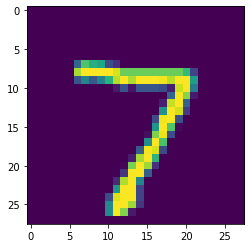

7
[[1.15582452e-03 2.67746447e-08 1.16429335e-04 2.06948188e-03
  8.10551285e-07 1.17924290e-04 2.96817182e-10 9.94935095e-01
  4.34446010e-05 1.56107615e-03]]
L1 Neurons
[0.32409063, -0.936691, 7.9421287, 7.055867, 10.667285, -0.28955138, 0.68159825, 5.3288164]
[ 0.32409063  0.          7.9421287   7.055867   10.667285    0.
  0.68159825  5.3288164 ]
L2 Neurons
[3.5074468, -7.1654243, 1.2121623, 4.0899286, -3.755162, 1.2249187, -11.667512, 10.265308, 0.22636178, 3.8080072]
[1.15582673e-03 2.67746429e-08 1.16429575e-04 2.06948048e-03
 8.10553729e-07 1.17924319e-04 2.96819125e-10 9.94935036e-01
 4.34445828e-05 1.56107754e-03]


In [0]:
def relu(x):
  return np.maximum(0, x)

testImageId = 0

testImage = x_test[testImageId]

plt.imshow(testImage)
plt.show()

print(y_test[testImageId])

testImage = image.img_to_array(testImage)

testImage = np.expand_dims(testImage, axis=0)

# testImage = np.vstack([testImage])

print(model.predict(testImage, batch_size=1))

imageX = len(testImage[0])
imageY = len(testImage[0][0])

testImageFlat = [item[0] for sublist in testImage[0] for item in sublist]

l1NeuronZ = [0] * len(neuronDict[0].keys())

for neuron in neuronDict[0].keys():
  l1NeuronZ[neuron] = neuronDict[0][neuron]["bias"]
  for synapse in range(len(testImageFlat)):
    l1NeuronZ[neuron] += testImageFlat[synapse] * neuronDict[0][neuron]["weights"][synapse]
    
# print(l1NeuronZ)

l1NeuronA = relu(l1NeuronZ)

print("L1 Neurons")
print(l1NeuronZ)
print(l1NeuronA)

l2NeuronZ = [0] * len(neuronDict[1].keys())


for neuron in neuronDict[1].keys():
  l2NeuronZ[neuron] = neuronDict[1][neuron]["bias"]
  for synapse in range(len(l1NeuronA)):
    l2NeuronZ[neuron] += l1NeuronA[synapse] * neuronDict[1][neuron]["weights"][synapse]
    
l2NeuronA = np.exp(l2NeuronZ)/sum(np.exp(l2NeuronZ))

print("L2 Neurons")
print(l2NeuronZ)
print(l2NeuronA)